In [ ]:
cd /home/drew/NBOH

In [335]:
import bioinf as bi
import subprocess as subp
import numpy as np

class Protein(object):
    def __init__(self, atoms, forces=np.array([])):
        does_have_forces = forces.size > 0
        if does_have_forces:
            assert(type(forces) == np.ndarray)
            assert(forces.shape == (len(atoms), 3))
        
        self._atoms = []
        residues = {}
        self._residues = []
        for i, atom_line in enumerate(atoms):
            atom = Atom(atom_line, forces[i]) if does_have_forces else Atom(atom_line)
            self._atoms.append(atom)
            res_atoms = residues.get(atom.resSeq, [])
            res_atoms.append(atom)
            residues[atom.resSeq] = res_atoms
        for res_atoms in residues.values():
            self._residues.append(Residue(res_atoms))

#     def set_forces(self, forces):
#         assert(forces.type = np.ndarray)
#         assert(force.shape = (len(atoms, 3)))
#         for i, atom in enumerate(self._atoms):
#             atom.set_force(forces[i])
    
    residues = property(lambda self: self._residues)
    atoms = property(lambda self: self._atoms)
        
class Residue(object):
    def __init__(self, atoms, forces=np.array([])):
        if forces.size > 0:
            assert(type(forces) == np.ndarray)
            assert(forces.shape == (len(atoms), 3))
            for i,force in enumerate(forces):
                atoms[i].set_force(force)
        self._atoms = atoms

#     def set_forces(self, forces):
#         assert(forces.type == np.ndarray)
#         assert(force.shape == (len(atoms, 3)))
#         for i, atom in enumerate(self._atoms):
#             atom.set_force(forces[i])
    atoms = property(lambda self: self._atoms)
    force = property(lambda self: np.sum(np.array([atom.force for atom in self._atoms]), axis=0))
    resSeq = property(lambda self: self._atoms[0].resSeq)
    resName = property(lambda self: self._atoms[0].resName)
    
class Atom(object):
    def __init__(self, atom_line, force=np.zeros(3)):
        self._atom_line = atom_line
        self._force = force
    
    def set_force(self, force):
        assert(type(force) == np.ndarray)
        assert(force.dtype == np.float64)
        self._force = force
    
    name = property(lambda self: self._atom_line.name)
    force = property(lambda self: self._force, set_force)
    resSeq = property(lambda self: self._atom_line.resSeq)
    resName = property(lambda self: self._atom_line.resName)


In [ ]:
ligand = "CMYH"
protein_atoms = []
ligand_atoms = []
first_ligand_index = None
last_ligand_index = None
 
with open('fullSystemStart.pdb') as pdb:
    current_atom_index = 0
    for line in pdb:
        cleanline = line.strip()
        if cleanline.startswith("ATOM"):
            atom_line = bi.PDBAtomLine.parse_string(cleanline)
            protein_atoms.append(atom_line)
            current_atom_index += 1
            continue
        if cleanline.startswith("HETATM"):
            hetatom_line = bi.PDBAtomLine.parse_string(cleanline)
            if hetatom_line.resName == ligand:
                first_ligand_index = current_atom_index if first_ligand_index == None else first_ligand_index
                ligand_atoms.append(hetatom_line)
            current_atom_index += 1
            continue
    #protein = Protein(protein_atoms)
    #ligand = Residue(ligand_atoms)
    last_ligand_index = first_ligand_index + len(ligand_atoms) - 1
    last_protein_index = len(protein_atoms) - 1

In [ ]:
#subprocess = subp.run(["gmx", "dump", "-f", "md_f.trr"], capture_output=True, text=True)

In [ ]:
current_atom_index = 0
frames = {}

from copy import deepcopy
%pip install pytrr
protein_atoms_copy = []
ligand_atoms_copy = []
time = 0.0

for line in subprocess.stdout.splitlines():
    cleanline = line.strip()
    if cleanline.startswith("natoms="): 
        #   natoms=     30390  step=         0  time=0.0000000e+00  lambda=         0
        current_atom_index = 0
        parts = cleanline.split("=")
        time = float(parts[3].split()) * 0.001 # ns in ps
        should_keep_frame = time % dt == 0
        protein_atoms_copy = deepcopy(protein_atoms)
        ligand_atoms_copy = deepcopy(ligand_atoms)
        continue
    if not should_keep_frame:
        continue
    if not cleanline.startswith('f['):
        continue

    #      f[    0]={ 1.00519e+03, -9.12023e+02,  7.50160e+02}
    parts = cleanline.split("=")
    #atom = int(parts[0].strip("f []"))
    force = np.array(parts[-1].strip(" {}").split(","), dtype=np.float64)
    if current_atom_index <= last_protein_index:
        protein_atoms_copy[current_atom_index].setForce(force)
    if current_atom_index >= first_ligand_index and current_atom_index <= last_ligand_index:
        ligand_atoms_copy[current_atom_index].setForce(force)
    if current_atom_index == last_ligand_index:
        frames[time] = {protein: Protein(protein_atoms_copy), ligand: Residue(ligand_atoms_copy)}
    current_atom_index += 1
    print(time, current_atom_index, end='\r')  

In [ ]:
from pytrr import GroTrrReader

In [ ]:
dt = 1 # in ns
span = 0.25 # in ns
times = np.array([])
should_keep_frame = True

with GroTrrReader('md_f.trr') as f:
    average_forces = {}
    forces = np.array([[[]]])
    for i,frame in enumerate(f):
        time = frame['time'] / 1000 # in ns
        should_keep_frame = ((time + span) % dt == 0) if (not should_keep_frame) else should_keep_frame  
        if not should_keep_frame:
            continue
        should_keep_frame = ((time - span) % dt != 0)
        force_array = np.array([f.get_data()['f']])
        forces = np.append(forces, force_array, axis=0) if forces.any() else force_array
        if not should_keep_frame:
            average_forces[time-span] = np.average(forces, axis=0)
            forces = np.array([[[]]])
    average_forces[time] = np.average(forces, axis=0)

In [336]:
from copy import deepcopy
molecules = {}
for time,atom_forces in average_forces.items():
    protein_atom_forces = atom_forces[0:last_protein_index+1]
    ligand_atom_forces = atom_forces[first_ligand_index:last_ligand_index+1]
    protein_atoms_copy = deepcopy(protein_atoms)
    ligand_atoms_copy = deepcopy(ligand_atoms)
    protein = Protein(protein_atoms_copy, protein_atom_forces)
    ligand = Residue([Atom(atom) for atom in ligand_atoms_copy], ligand_atom_forces)
    molecules[time] = {'protein': protein, 'ligand': ligand}

In [321]:
import seaborn as sb
import pandas as pd

residues = {time: molecule['protein'].residues + [molecule['ligand']] for time, molecule in molecules.items()}
forces_arr = {time: [residue.force for residue in residues_t] for time, residues_t in residues.items()}
force_norms = {time: [np.linalg.norm(force) for force in force_t] for time, force_t in forces_arr.items()}
df = pd.DataFrame(force_norms, index=[residue.resName + residue.resSeq for residue in residues[0]])

<AxesSubplot:>

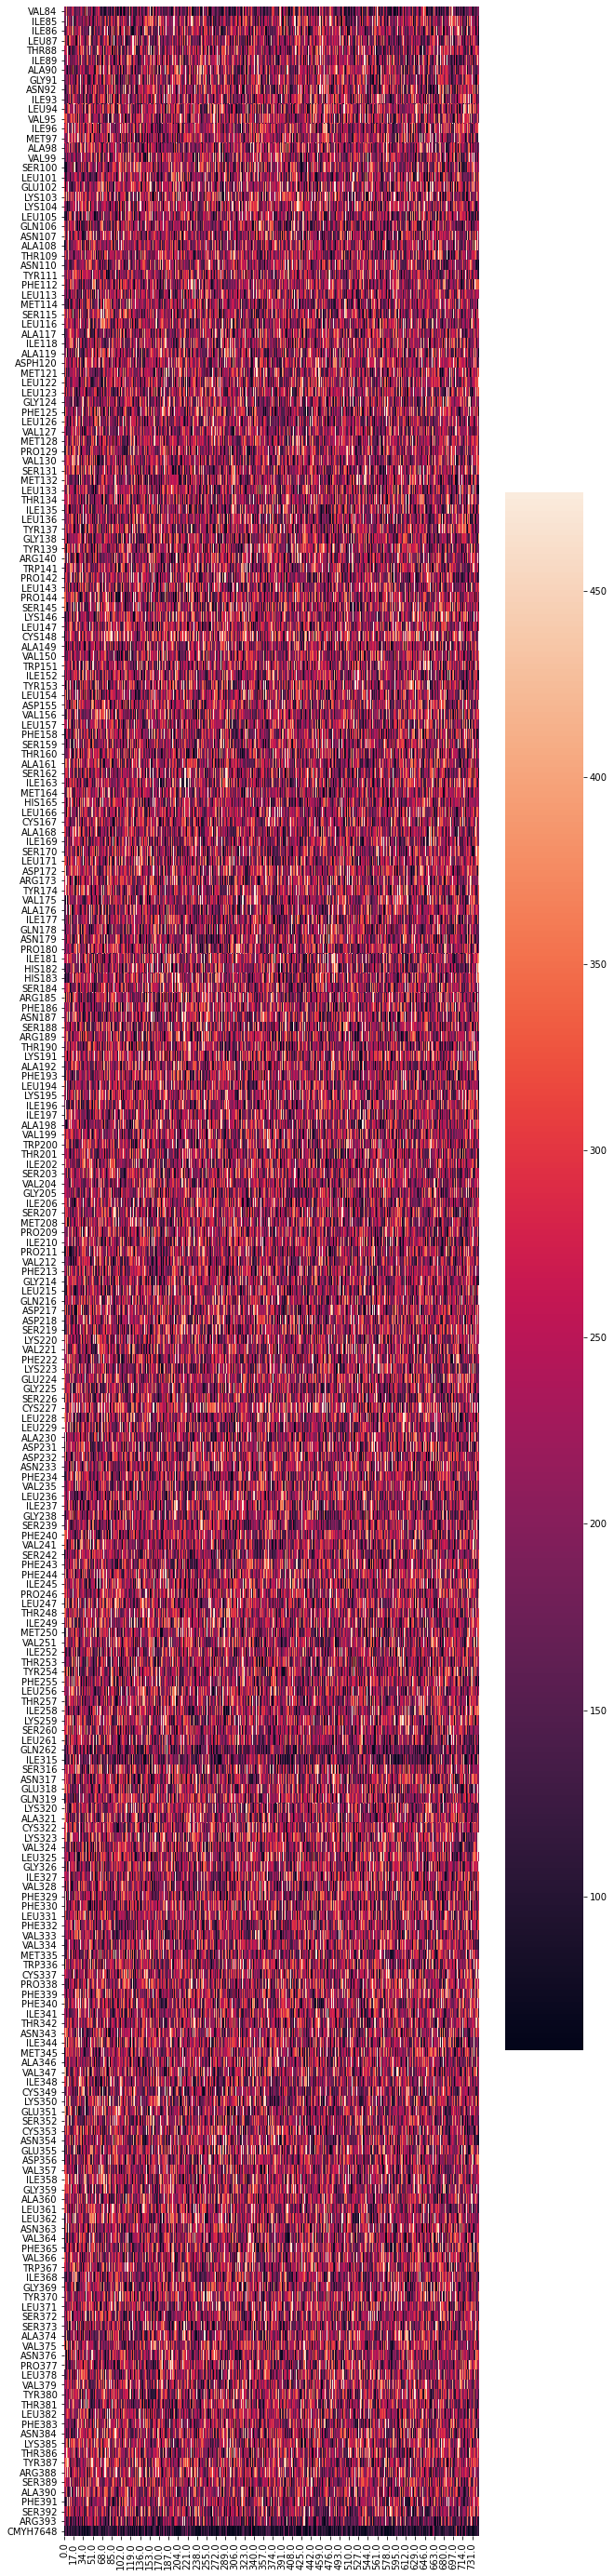

In [323]:
import matplotlib.pyplot as plt 
plot = plt.figure(figsize=(10, 50))
sb.heatmap(df, robust=True)
plt.savefig(f'forcesVTime_window{span}.png')

In [337]:
with open("atoms", 'w') as f:
    f.write('t, #, atom_name, res type, res #, f_x, f_y, f_z\n')
    for time in molecules:
        mols = molecules[time]
        prot = mols['protein']
        lig = mols['ligand']
        for i, atom in enumerate(prot.atoms):
            f.write(f'{time}, {i}, {atom.name}, {atom.resName}, {atom.resSeq}, {atom.force[0]}, {atom.force[1]}, {atom.force[2]}\n')
        for i, atom in enumerate(lig.atoms):
            f.write(f'{time}, {i}, {atom.name}, {atom.resName}, {atom.resSeq}, {atom.force[0]}, {atom.force[1]}, {atom.force[2]}\n')
       

In [325]:
molecules[0]

{'protein': <__main__.Protein at 0x7fcf00a1bfd0>,
 'ligand': <__main__.Residue at 0x7fcf0048f3a0>}